# AIPI 590 - XAI | Mechanistic Interpretability
### A tiny neural network for XOR classification
### Mariam Khan

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Mkhan13/XAI/blob/main/mechanistic_interpretability.ipynb
)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# **Part 1 - Setup**

### XOR Data Generation

In [2]:
X = torch.tensor([[0,0],[0,1],[1,0],[1,1]], dtype=torch.float32)
y = torch.tensor([[0],[1],[1],[0]], dtype=torch.float32)

### Build a Tiny MLP (multilayer perceptron) Model

In [3]:
class TinyXOR(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 4)
        self.out = nn.Linear(4, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        hidden = torch.sigmoid(self.hidden(x))
        pred = torch.sigmoid(self.out(hidden))
        return pred, hidden

model = TinyXOR()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)

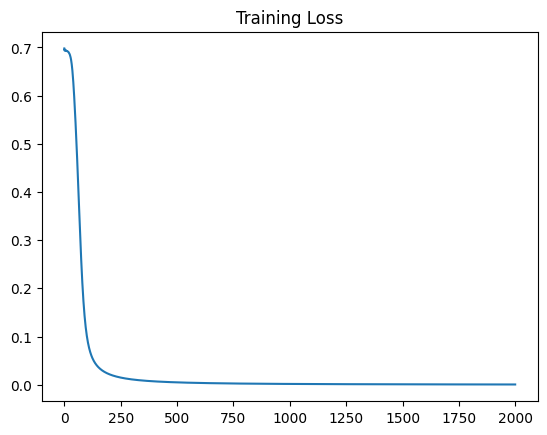

In [4]:
# Train
losses = []
for epoch in range(2000):
    optimizer.zero_grad()
    pred, hidden = model(X)
    loss = criterion(pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plt.plot(losses)
plt.title("Training Loss")
plt.show()

### Test predictions

In [5]:
with torch.no_grad():
    pred, hidden = model(X) # Get predictions and hidden activations
print(torch.round(pred))

tensor([[0.],
        [1.],
        [1.],
        [0.]])


# **Part 2 - Explore**

### Get hidden layer activations

In [6]:
hidden = hidden.numpy() # Convert tensor to numpy
print("Hidden layer activations:")
print(hidden)

Hidden layer activations:
[[0.91851455 0.8781438  0.90647465 0.31519946]
 [0.9999976  0.9999856  0.00759775 0.99790525]
 [0.0085993  0.01650591 0.99999547 0.99757713]
 [0.9968875  0.9938292  0.99422956 0.9999976 ]]


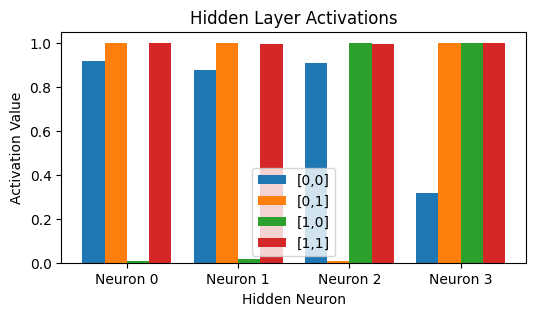

In [12]:
plt.figure(figsize=(6,3))
x_positions = np.arange(hidden.shape[1])

for index, label in enumerate(["[0,0]", "[0,1]", "[1,0]", "[1,1]"]):
    plt.bar(x_positions + index*0.2, hidden[index], width=0.2, label=label)

plt.xticks(x_positions + 0.3, [f"Neuron {i}" for i in range(hidden.shape[1])])
plt.legend()
plt.xlabel("Hidden Neuron")
plt.ylabel("Activation Value")
plt.title("Hidden Layer Activations")
plt.show()

### Get weights and biases

In [8]:
weight_hidden = model.hidden.weight.data.numpy()
bias_hidden = model.hidden.bias.data.numpy()

weight_out = model.out.weight.data.numpy()
bias_out = model.out.bias.data.numpy()

print("Hidden Layer Weights:")
print(weight_hidden)
print("Hidden Layer Biases:")
print(bias_hidden)
print("Output Layer Weights:")
print(weight_out)
print("Output Layer Bias:")
print(bias_out)

Hidden Layer Weights:
[[-7.169771  10.51665  ]
 [-6.0623617  9.169121 ]
 [10.021484  -7.143607 ]
 [ 6.7962976  6.9421153]]
Hidden Layer Biases:
[ 2.4223337  1.9749683  2.2713306 -0.775922 ]
Output Layer Weights:
[[ -8.442671  -6.985136 -14.704369  10.323743]]
Output Layer Bias:
[12.496443]


# **Part 3 - Explain**

# **Part 4 - Reflect**